In [395]:
import pandas as pd
import numpy as np
import glob
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, confusion_matrix, accuracy_score

In [232]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [233]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../Downloads/premierleague/season-*.csv"))))

In [234]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,SBH,SBD,SBA
0,E0,18/08/12,Arsenal,Sunderland,0,0,D,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,18/08/12,Fulham,Norwich,5,0,H,2,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,18/08/12,Newcastle,Tottenham,2,1,H,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,18/08/12,QPR,Swansea,0,5,A,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,18/08/12,Reading,Stoke,1,1,D,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Missing Data Imputation

In [235]:
def missing_cnt_percent(df):
    # create df that consists of columns and the number of missing values for each 
    data = df.isnull().sum().sort_values(ascending=False)
    missing_df = pd.DataFrame(data=data, columns=['missing_cnt'])

    # add column and fill it with the percentage of those missing values
    missing_df['percent_missing'] = missing_df.missing_cnt.apply(lambda x : '{:.2f}'.format(x/df.shape[0] * 100)) 
    missing_df = missing_df[missing_df.missing_cnt > 0]
    return missing_df

In [236]:
missing_cnt_percent(df)

,missing_cnt,percent_missing
AvgAHA,3800,86.03
B365AHA,3800,86.03
IWCH,3800,86.03
BWCA,3800,86.03
BWCD,3800,86.03
...,...,...
BWA,1,0.02
BWH,1,0.02
IWH,1,0.02
BWD,1,0.02


In [237]:
drop_cols = ['SBA','SBH','SBD','GBH','GBD','GBA','BSA','BSH','BSD'
             , 'SJH','SJD','SJA', 'Time']

In [238]:
for col in drop_cols:
    df.drop(col, axis=1, inplace=True)

In [239]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,18/08/12,Arsenal,Sunderland,0,0,D,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,18/08/12,Fulham,Norwich,5,0,H,2,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,18/08/12,Newcastle,Tottenham,2,1,H,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,18/08/12,QPR,Swansea,0,5,A,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,18/08/12,Reading,Stoke,1,1,D,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
df = df.fillna(df.mean())

In [241]:
missing_cnt_percent(df)

,missing_cnt,percent_missing


In [242]:
df['Date'] = pd.to_datetime(df.Date)

In [243]:
df['Game_Month'] = pd.DatetimeIndex(df['Date']).month

In [287]:
df['Game_Year'] = pd.DatetimeIndex(df['Date']).year

In [245]:
df['Game_Day'] = pd.DatetimeIndex(df['Date']).day

In [283]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgCAHH,AvgCAHA,Game_Month,Game_Year,Game_Day,HTR_Num,FTR_Num,AwayTeam_Num,HomeTeam_Num,Referee_Num
0,E0,2012-08-18,Arsenal,Sunderland,0,0,D,0,0,D,...,1.937893,1.946904,8,2012,18,0,0,32.0,6.0,2.0
1,E0,2012-08-18,Fulham,Norwich,5,0,H,2,0,H,...,1.937893,1.946904,8,2012,18,1,1,20.0,16.0,7.0
2,E0,2012-08-18,Newcastle,Tottenham,2,1,H,0,0,D,...,1.937893,1.946904,8,2012,18,0,1,5.0,11.0,4.0
3,E0,2012-08-18,QPR,Swansea,0,5,A,0,1,A,...,1.937893,1.946904,8,2012,18,-1,-1,22.0,30.0,16.0
4,E0,2012-08-18,Reading,Stoke,1,1,D,0,1,A,...,1.937893,1.946904,8,2012,18,-1,0,23.0,25.0,11.0


# Categorizing Data

In [247]:
# Halftime results 
htr = {
    "H" : 1,
    "A" : -1,
    "D" : 0
}
# create numerical column for HTR
df["HTR_Num"] = df.HTR.map(htr)

In [248]:
# create numerical column for FTR
df["FTR_Num"] = df.FTR.map(htr)

In [249]:
# team categorized based on team's market value
team = {
    "Liverpool" : 1
    ,"Man City" : 2
    ,"Chelsea" : 3
    ,"Man United" : 4
    ,"Tottenham" : 5
    ,"Arsenal" : 6
    ,"Everton" : 7
    ,"Leicester" : 8
    ,"Wolves" : 9
    ,"Aston Villa" : 10
    ,"Newcastle" : 11
    ,"West Ham" : 12
    ,"Brighton" : 13
    ,"Southampton" : 14
    ,"Crystal Palace" : 15
    ,"Fulham" : 16
    ,"Burnley" : 17
    ,"West Brom" : 18
    ,"Bournemouth" : 19
    ,"Norwich" : 20
    ,"Watford" : 21
    ,"Swansea" : 22
    ,"Stoke" : 23
    ,"Blackburn" : 24
    ,"Reading" : 25
    ,"Cardiff" : 26
    ,"Birmingham" : 27
    ,"Huddersfield" : 28
    ,"Middlesbrough" : 29
    ,"QPR" : 30
    ,"Hull" : 31
    ,"Sunderland" : 32
    ,"Blackpool" : 33
    ,"Portsmouth" : 34
    ,"Wigan" : 35
    ,"Bolton" : 36
}
df["AwayTeam_Num"] = df.AwayTeam.map(team)

In [250]:
df["HomeTeam_Num"] = df.HomeTeam.map(team)

In [251]:
# refs categorized based on number of game appearances
ref = {
    "M Clattenburg" : 1
    ,"C Foy" : 2
    ,"P Walton" : 3
    ,"M Atkinson" : 4
    ,"Mn Atkinson" : 5
    ,"M Dean" : 6
    ,"M Oliver" : 7
    ,"A Taylor" : 8
    ,"A Marriner" : 9
    ,"L Mason" : 10
    ,"K Friend" : 11
    ,"J Moss" : 12
    ,"M Jones" : 13
    ,"C Pawson" : 14
    ,"S Attwell" : 15
    ,"L Probert" : 16
    ,"K Stroud" : 17
    ,"H Webb" : 18
    ,"S Hooper" : 19
    ,"A Madley" : 20
    ,"P Tierney" : 21
    ,"P Dowd" : 22
    ,"N Swarbrick" : 23
    ,"C Kavanagh" : 24
    ,"D Coote" : 25
    ,"G Scott" : 26
    ,"R Madley" : 27
    ,"R East" : 28
    ,"M Halsey" : 29
    ,"S Bennett" : 30
    ,"St Bennett" : 31
    ,"A Wiley" : 32
}

df['Referee_Num'] = df.Referee.map(ref)

In [252]:
# dictionary to rank teams
team_rank = {
    
}

In [278]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgCAHH,AvgCAHA,Game_Month,Game_Year,Game_Day,HTR_Num,FTR_Num,AwayTeam_Num,HomeTeam_Num,Referee_Num
0,E0,2012-08-18,Arsenal,Sunderland,0,0,D,0,0,D,...,1.937893,1.946904,8,2012,18,0,0,32.0,6.0,2.0
1,E0,2012-08-18,Fulham,Norwich,5,0,H,2,0,H,...,1.937893,1.946904,8,2012,18,1,1,20.0,16.0,7.0
2,E0,2012-08-18,Newcastle,Tottenham,2,1,H,0,0,D,...,1.937893,1.946904,8,2012,18,0,1,5.0,11.0,4.0
3,E0,2012-08-18,QPR,Swansea,0,5,A,0,1,A,...,1.937893,1.946904,8,2012,18,-1,-1,22.0,30.0,16.0
4,E0,2012-08-18,Reading,Stoke,1,1,D,0,1,A,...,1.937893,1.946904,8,2012,18,-1,0,23.0,25.0,11.0


In [386]:
# get count of Home wins per year
df_grp_h = df[df["FTR_Num"] == 1].groupby(['Game_Year'])['FTR_Num'].count().reset_index(name='Home_Wins')

In [387]:
# get count of Away wins per year
df_grp_a = df[df["FTR_Num"] == -1].groupby(['Game_Year'])['FTR_Num'].count().reset_index(name='Away_Wins')

In [388]:
# get count of Draws per year
df_grp_d = df[df["FTR_Num"] == 0].groupby(['Game_Year'])['FTR_Num'].count().reset_index(name='Draws')

In [397]:
# merged the dataframes into one
dataframes = [df_grp_h, df_grp_a, df_grp_d]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Game_Year'],
                                            how='outer'), dataframes)

# TODO: Get Home Win Pct for each year
df_merged['Home_Win_Pct'] = 
df_merged

,Game_Year,Home_Wins,Away_Wins,Draws
0,2009,100,49,47
1,2010,176,89,109
2,2011,172,104,101
3,2012,181,109,101
4,2013,166,111,95
5,2014,175,120,85
6,2015,163,122,95
7,2016,175,108,95
8,2017,188,115,98
9,2018,172,117,82


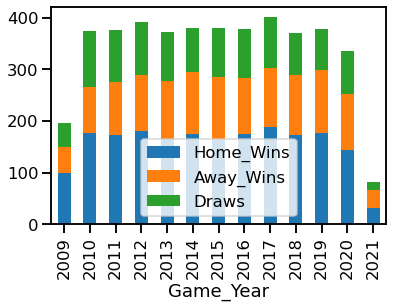

In [409]:
df_merged.plot.bar(stacked=True, x='Game_Year')

(2008.0, 2022.0)

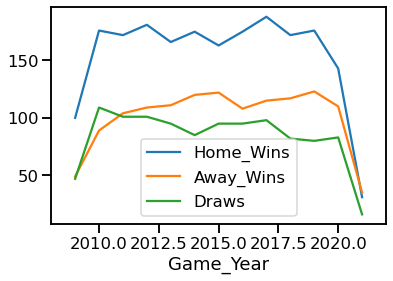

In [407]:
df_merged.plot.line(x='Game_Year', y=['Home_Wins','Away_Wins','Draws'])
plt.xlim(2008,2022)

In [225]:
# shows correlation between columns and the game results (FTR_Num)
corr_matrix = df.corr()
corr_matrix['FTR_Num'] = round(corr_matrix['FTR_Num'],4)
print_full(corr_matrix['FTR_Num'].sort_values(ascending=False))

FTR_Num         1.0000
FTHG            0.6246
HTR_Num         0.6129
HTHG            0.4368
BWA             0.3486
IWA             0.3484
B365A           0.3466
VCA             0.3399
WHA             0.3396
HST             0.3281
BbAvA           0.3272
BbMxA           0.3161
PSCA            0.3077
PSA             0.3039
LBA             0.3014
AwayTeam_Num    0.2501
HS              0.2264
VCD             0.1867
B365D           0.1847
BbAvD           0.1832
BbMxD           0.1832
BWD             0.1826
IWD             0.1816
LBD             0.1789
WHD             0.1758
PSD             0.1636
PSCD            0.1552
BbMx<2.5        0.1372
BbAv<2.5        0.1366
B365CA          0.1177
VCCA            0.1170
IWCA            0.1169
WHCA            0.1167
AvgCA           0.1162
AvgA            0.1160
BWCA            0.1137
MaxA            0.1109
MaxCA           0.1098
AR              0.0930
BbAvAHA         0.0898
BbMxAHA         0.0867
HC              0.0713
BWCD            0.0557
VCCD       

In [226]:
# get columns that have a correlation value of less than 10%
uncorrelated_cols = corr_matrix[(corr_matrix.FTR_Num<0.10) & (corr_matrix.FTR_Num>-1.0)].FTR_Num.sort_values(ascending=False).index

In [227]:
for col in uncorrelated_cols:
    df.drop(col, axis=1, inplace=True)

In [228]:
# Drop the columns that are not numerical (they are replaced with numerical columns)
object_cols = ['Div','Date','HomeTeam','AwayTeam','FTR','HTR','Referee']

for obj in object_cols:
    df.drop(obj, axis=1, inplace=True)

In [229]:
df.head()

,FTHG,HTHG,HS,HST,B365D,B365A,BWD,BWA,IWD,IWA,...,B365CA,BWCA,IWCA,WHCA,VCCA,MaxCA,AvgCA,HTR_Num,FTR_Num,AwayTeam_Num
0,0,0,14,4,4.50,8.50,4.6,9.00,4.5,7.3,...,4.477407,4.552869,4.350681,4.683128,4.689141,5.187034,4.588412,0,0,32.0
1,5,2,11,9,3.60,4.50,3.5,4.40,3.4,4.0,...,4.477407,4.552869,4.350681,4.683128,4.689141,5.187034,4.588412,1,1,20.0
2,2,0,6,4,3.40,2.75,3.3,2.75,3.2,2.7,...,4.477407,4.552869,4.350681,4.683128,4.689141,5.187034,4.588412,0,1,5.0
3,0,0,20,11,3.40,3.80,3.4,3.60,3.3,3.1,...,4.477407,4.552869,4.350681,4.683128,4.689141,5.187034,4.588412,-1,-1,22.0
4,1,0,9,3,3.25,3.10,3.2,3.10,3.2,2.7,...,4.477407,4.552869,4.350681,4.683128,4.689141,5.187034,4.588412,-1,0,23.0


In [230]:
# make sure all columns are numerical
df.dtypes

FTHG              int64
HTHG              int64
HS                int64
HST               int64
B365D           float64
B365A           float64
BWD             float64
BWA             float64
IWD             float64
IWA             float64
LBD             float64
LBA             float64
PSD             float64
PSA             float64
WHD             float64
WHA             float64
VCD             float64
VCA             float64
BbMxD           float64
BbAvD           float64
BbMxA           float64
BbAvA           float64
BbMx<2.5        float64
BbAv<2.5        float64
PSCD            float64
PSCA            float64
MaxA            float64
AvgA            float64
B365CA          float64
BWCA            float64
IWCA            float64
WHCA            float64
VCCA            float64
MaxCA           float64
AvgCA           float64
HTR_Num           int64
FTR_Num           int64
AwayTeam_Num    float64
dtype: object

# Standardization

In [126]:
# TODO : Standardize dataframe

# x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)

In [ ]:
# TODO : Train models